In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import randint, uniform
from statsmodels.regression.mixed_linear_model import MixedLM

In [ ]:
file_path = "/content/NGAsub_MegaFlatfile_RotD50_050_R211022_public.xlsx"
df = pd.read_excel(file_path)

In [ ]:
df.rename(columns={
    'PGA_g': 'pga',
    'Earthquake_Magnitude': 'mag',
    'Rjb_km': 'rjb',
    'Hypocenter_Depth_km': 'hypd',
    'Vs30_Selected_for_Analysis_m_s': 'vs30',
    'Intra_Inter_Flag': 'intra_inter',
    'Sensor_Depth_m': 'sensor_depth',
    'Multiple_Event': 'multi_event',
    'Late_P_trigger_flag_1ptYes_0ptNo': 'late_flag',
    'Source_review_flag': 'src_flag',
    'Longest_Usable_Period_for_PSa_Ave_Component_sec': 'tgm',
    'NGAsubEQID': 'EqID',
    'Station_Name':'siteID'
}, inplace=True)

In [ ]:
df = df[(df['pga'] != -999) & (df['pga'] <= 10) & (df['mag'] >= 4)]

meta_cols = ['mag', 'rjb', 'hypd', 'vs30',"Ztor_km"]
for col in meta_cols:
    df = df[df[col] != -999]

df = df[df['intra_inter'].isin([0, 1, 5])]

is_interface = (df['intra_inter'] == 0) & (df['hypd'] < 40)
is_intraslab = (df['intra_inter'] == 1) & (df['hypd'] < 200)
df = df[is_interface | is_intraslab]

df = df[df['rjb'] <= 1000]

df = df[df['sensor_depth'] <= 2]

df = df[df['multi_event'] != 1]

df = df[df['late_flag'] != 1]

df = df[df['src_flag'].isin([0, 1, 2, 4])]

df = df[df['tgm'] >= 10]

event_counts = df['EqID'].value_counts()
valid_eids = event_counts[event_counts >= 3].index
df = df[df['EqID'].isin(valid_eids)]
df.shape

(14526, 227)

In [ ]:
input_cols = ['mag', 'rjb', 'logrjb', 'logvs30', 'intra_inter']
target_cols = [
    "T0pt010S", "T0pt020S", "T0pt030S", "T0pt050S", "T0pt075S",
    "T0pt100S", "T0pt150S", "T0pt200S", "T0pt300S", "T0pt400S",
    "T0pt500S", "T0pt750S", "T1pt000S", "T1pt500S", "T2pt000S",
    "T2pt500S", "T3pt000S", "T3pt500S", "T4pt000S", "T5pt000S"
]

df['rjb'] = df['rjb'].replace(0, 0.01).replace([np.inf, -np.inf], np.nan)
df['vs30'] = df['vs30'].astype(float).replace(0, 0.01).replace([np.inf, -np.inf], np.nan)

# Log-transform rjb and vs30
df['logrjb'] = np.log10(df['rjb'])
df['logvs30'] = np.log10(df['vs30'])

# Drop any rows with NaN
df = df.dropna(subset=input_cols + target_cols)

# Extract inputs and targets
inputs = df[input_cols].values
targets = df[target_cols].values

# >>>>> Correct: Apply natural log to targets <<<<<
targets = np.log(targets)

# Normalize inputs and targets separately
scaler_input = StandardScaler()
scaler_target = StandardScaler()

inputs_scaled = scaler_input.fit_transform(inputs)
targets_scaled = scaler_target.fit_transform(targets)

# Save EqID and SiteID for residual calculations
EqIDs = df['EqID'].values
siteIDs = df['siteID'].values

# Train-validation-test split (randomized split)
X_train, X_temp, y_train, y_temp, EqID_train, EqID_temp, siteID_train, siteID_temp = train_test_split(
    inputs_scaled, targets_scaled, EqIDs, siteIDs, test_size=0.3, random_state=42)

X_val, X_test, y_val, y_test, EqID_val, EqID_test, siteID_val, siteID_test = train_test_split(
    X_temp, y_temp, EqID_temp, siteID_temp, test_size=0.5, random_state=42)

In [ ]:
base_gbr = GradientBoostingRegressor(
    n_estimators=3000,
    learning_rate=0.01,
    max_depth=3,
    subsample=0.8,
    min_samples_leaf=10,
    max_features=None,
    random_state=42,
    loss='squared_error'
)

model = MultiOutputRegressor(base_gbr)

# Initialize tracking
max_iterations = 15
NoOfOutput = y_train.shape[1]
LH = np.zeros((max_iterations, NoOfOutput))
LHR = np.zeros((max_iterations, NoOfOutput))

best_model = None
best_iteration = 0
min_val_loss = float("inf")

# Iterative training with mixed-effect residual decomposition
for iteration in range(max_iterations):
    print(f"\n--- Iteration {iteration + 1}/{max_iterations} ---")

    # Fit model
    model.fit(X_train, y_train)

    # Predict and evaluate on validation set
    y_val_pred = model.predict(X_val)
    val_loss = mean_squared_error(y_val, y_val_pred)

    # Update best model
    if val_loss < min_val_loss:
        best_model = model
        min_val_loss = val_loss
        best_iteration = iteration + 1

    # Predict on full data (log space)
    y_pred_scaled = model.predict(inputs_scaled)
    y_pred_log = scaler_target.inverse_transform(y_pred_scaled)
    y_true_log = scaler_target.inverse_transform(targets_scaled)
    residuals = y_true_log - y_pred_log

    # Mixed effects residual decomposition
    inter_event = np.zeros((len(np.unique(EqIDs)), NoOfOutput))
    intra_event = np.zeros((residuals.shape[0], NoOfOutput))

    for i in range(NoOfOutput):
        df_data = pd.DataFrame({
            'residual': residuals[:, i],
            'EqID': EqIDs,
            'siteID': siteIDs
        })

        mixed_model = MixedLM.from_formula("residual ~ 1", groups="EqID", re_formula="1", data=df_data)
        result = mixed_model.fit()

        # Inter-event residuals
        group_effects = result.random_effects
        unique_eqids = np.unique(EqIDs)
        for j, eqid in enumerate(unique_eqids):
            inter_event[j, i] = group_effects[eqid].iloc[0]

        # Intra-event residuals
        for j in range(len(EqIDs)):
            eq_index = np.where(unique_eqids == EqIDs[j])[0][0]
            intra_event[j, i] = residuals[j, i] - inter_event[eq_index, i]

    # Compute training loss per output
    y_train_pred = model.predict(X_train)
    loss_per_output = ((y_train - y_train_pred) ** 2).mean(axis=0)
    LH[iteration, :] = loss_per_output

    # Compute relative change
    if iteration > 0:
        denom = np.abs(LH[iteration - 1, :]) + 1e-8
        LHR[iteration, :] = (LH[iteration, :] - LH[iteration - 1, :]) * 100 / denom

    # Early stopping
    if iteration > 1 and np.max(np.abs(LHR[iteration, :])) < 10:
        print(f"Early stopping at iteration {iteration + 1}")
        break

print(f"Best model found at iteration {best_iteration} with val_loss: {min_val_loss:.5f}")


--- Iteration 1/15 ---

--- Iteration 2/15 ---

--- Iteration 3/15 ---
Early stopping at iteration 3
Best model found at iteration 1 with val_loss: 0.11875


In [ ]:
from scipy.stats import pearsonr
from sklearn.metrics import r2_score

# Assuming y_true_log and y_pred_log are your log-transformed true and predicted values
def calculate_correlation(y_true, y_pred):
    correlations = []
    for i in range(y_true.shape[1]):
        corr, _ = pearsonr(y_true[:, i], y_pred[:, i])
        correlations.append(corr)
    return correlations

def calculate_pp(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    sigma = np.std(y_true)
    PP = 1 / (mse / sigma)
    return PP

def calculate_slope(y_true, y_pred):
    Y_mean = np.mean(y_true, axis=0)
    y_mean = np.mean(y_pred, axis=0)
    numerator = np.sum((y_true - Y_mean) * (y_pred - y_mean), axis=0)
    denominator = np.sum((y_true - Y_mean)**2, axis=0)
    k = numerator / denominator
    return k

def calculate_r2(y_true, y_pred):
    return r2_score(y_true, y_pred, multioutput='uniform_average')

def calculate_a(R_model, R_target):
    return np.abs(R_model - R_target)

# Calculate performance parameters
R = calculate_correlation(y_true_log, y_pred_log)
PP = calculate_pp(y_true_log, y_pred_log)
k = calculate_slope(y_true_log, y_pred_log)
R_squared = calculate_r2(y_true_log, y_pred_log)

# Target R² (assumed to be close to 1 for best performance)
R_target = 1
a = calculate_a(R_squared, R_target)

# Print results
print(f"Correlation Coefficients (R): {R}")
print(f"Performance Parameter (PP): {PP}")
print(f"Slope (k): {k}")
print(f"R²: {R_squared}")
print(f"a: {a}")

Correlation Coefficients (R): [np.float64(0.9539159927348807), np.float64(0.9536548382177916), np.float64(0.9529717614383579), np.float64(0.9500726160710733), np.float64(0.9456036621817022), np.float64(0.9429860403124419), np.float64(0.944528571976955), np.float64(0.9469532221854498), np.float64(0.9515024001964848), np.float64(0.9538972582584367), np.float64(0.9543714625103964), np.float64(0.9520628878789521), np.float64(0.9489345885211562), np.float64(0.9442127210142317), np.float64(0.9436687329174323), np.float64(0.9452513242151525), np.float64(0.9474150712446399), np.float64(0.9497116258063845), np.float64(0.952466956435547), np.float64(0.9574481691228931)]
Performance Parameter (PP): 4.9422412202880635
Slope (k): [0.8974507  0.89689292 0.89550965 0.88911501 0.8792872  0.87365893
 0.87582507 0.88041747 0.89186087 0.89831953 0.90017133 0.89606147
 0.89031288 0.87942032 0.87688469 0.8806513  0.88404072 0.88962141
 0.8953313  0.90610306]
R²: 0.9015340837343647
a: 0.09846591626563528


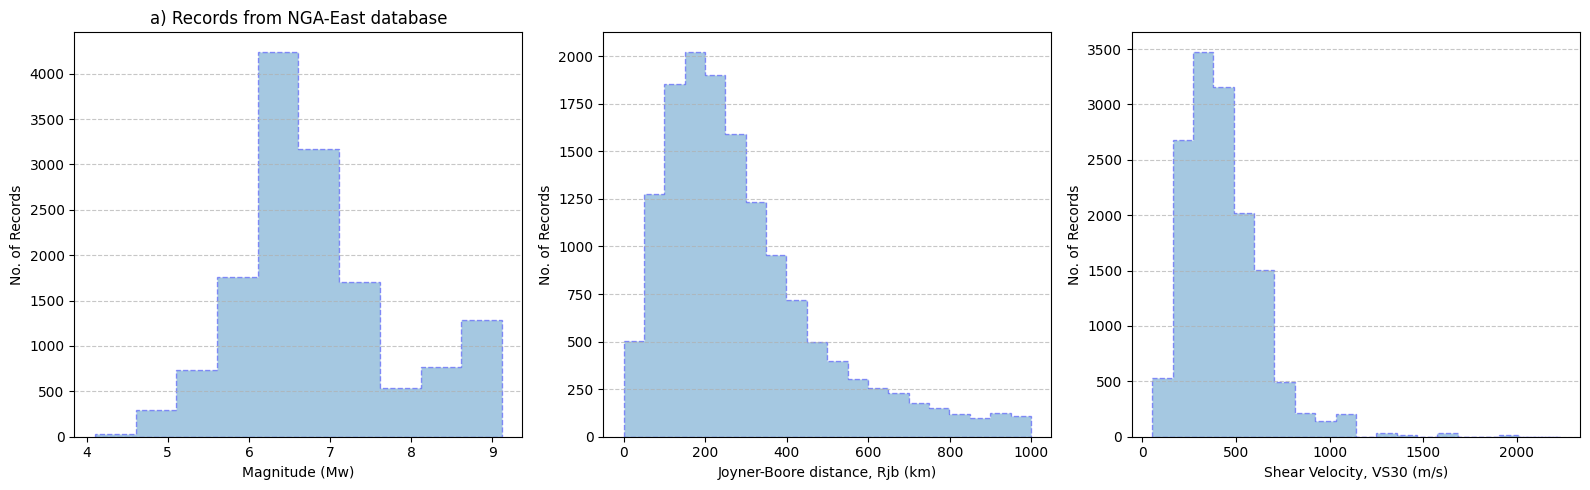

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(16, 5))

axs[0].hist(df["mag"], bins=10, edgecolor='blue', linestyle='--', histtype='stepfilled', alpha=0.4)
axs[0].set_xlabel("Magnitude (Mw)")
axs[0].set_ylabel("No. of Records")
axs[0].set_title("a) Records from NGA-East database")
axs[0].grid(axis='y', linestyle='--', alpha=0.7)

axs[1].hist(df["rjb"], bins=20, edgecolor='blue', linestyle='--', histtype='stepfilled', alpha=0.4)
axs[1].set_xlabel("Joyner-Boore distance, Rjb (km)")
axs[1].set_ylabel("No. of Records")
axs[1].grid(axis='y', linestyle='--', alpha=0.7)

axs[2].hist(df["vs30"], bins=20, edgecolor='blue', linestyle='--', histtype='stepfilled', alpha=0.4)
axs[2].set_xlabel("Shear Velocity, VS30 (m/s)")
axs[2].set_ylabel("No. of Records")
axs[2].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

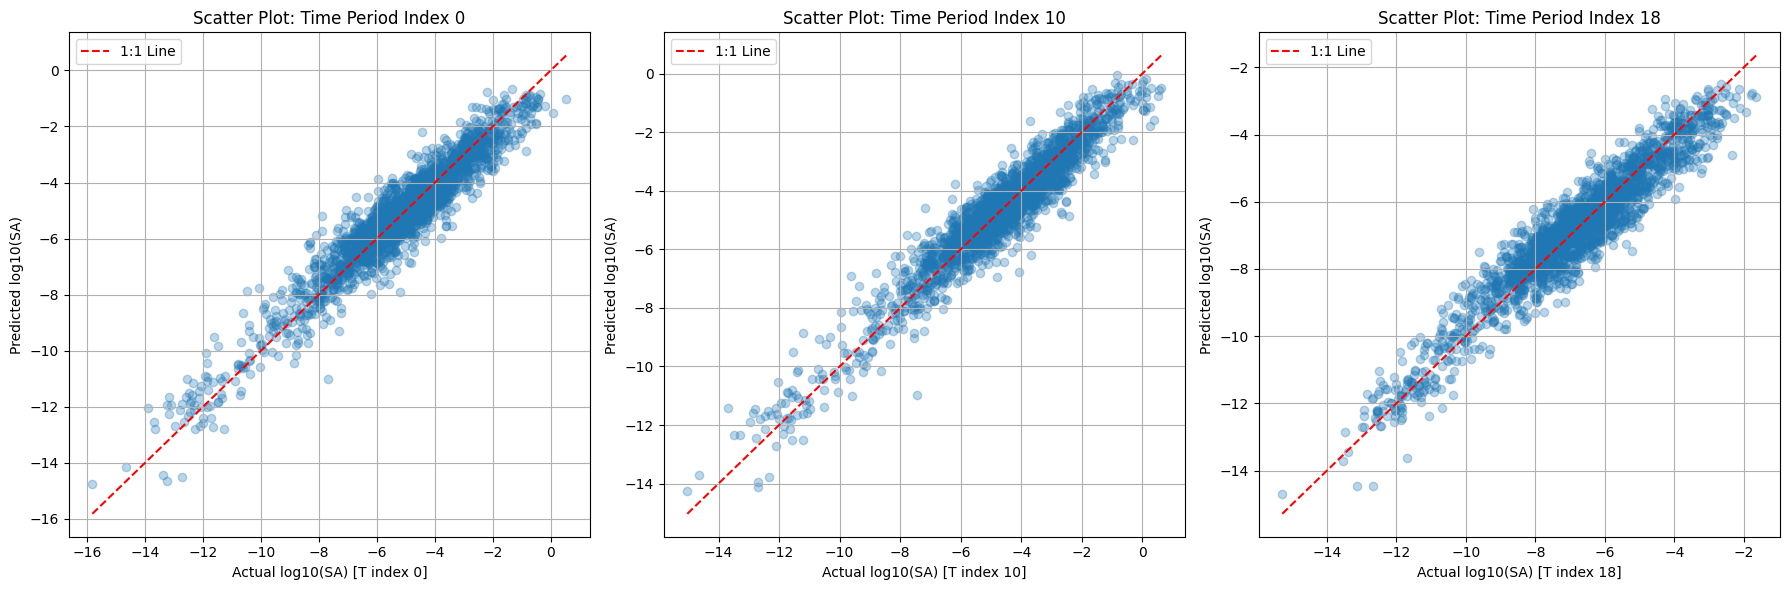

In [ ]:
spectral_indices = [0, 10, 18]

# Get original log-space values (no exp if already in log)
Y_test_log = scaler_target.inverse_transform(y_test)
Y_pred_scaled = best_model.predict(X_test)
Y_pred_log = scaler_target.inverse_transform(Y_pred_scaled)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for i, idx in enumerate(spectral_indices):
    ax = axs[i]
    ax.scatter(Y_test_log[:, idx], Y_pred_log[:, idx], alpha=0.3)
    ax.plot([Y_test_log[:, idx].min(), Y_test_log[:, idx].max()],
            [Y_test_log[:, idx].min(), Y_test_log[:, idx].max()], 'r--', label='1:1 Line')

    ax.set_xlabel(f'Actual log10(SA) [T index {idx}]')
    ax.set_ylabel('Predicted log10(SA)')
    ax.set_title(f'Scatter Plot: Time Period Index {idx}')
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

<ipython-input-11-9b1e561be3c7>:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_centers = df.groupby('bin')['x'].mean()
<ipython-input-11-9b1e561be3c7>:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = df.groupby('bin')['y'].mean()
<ipython-input-11-9b1e561be3c7>:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stds = df.groupby('bin')['y'].std()
<ipython-input-11-9b1e561be3c7>:12: FutureWarning: T

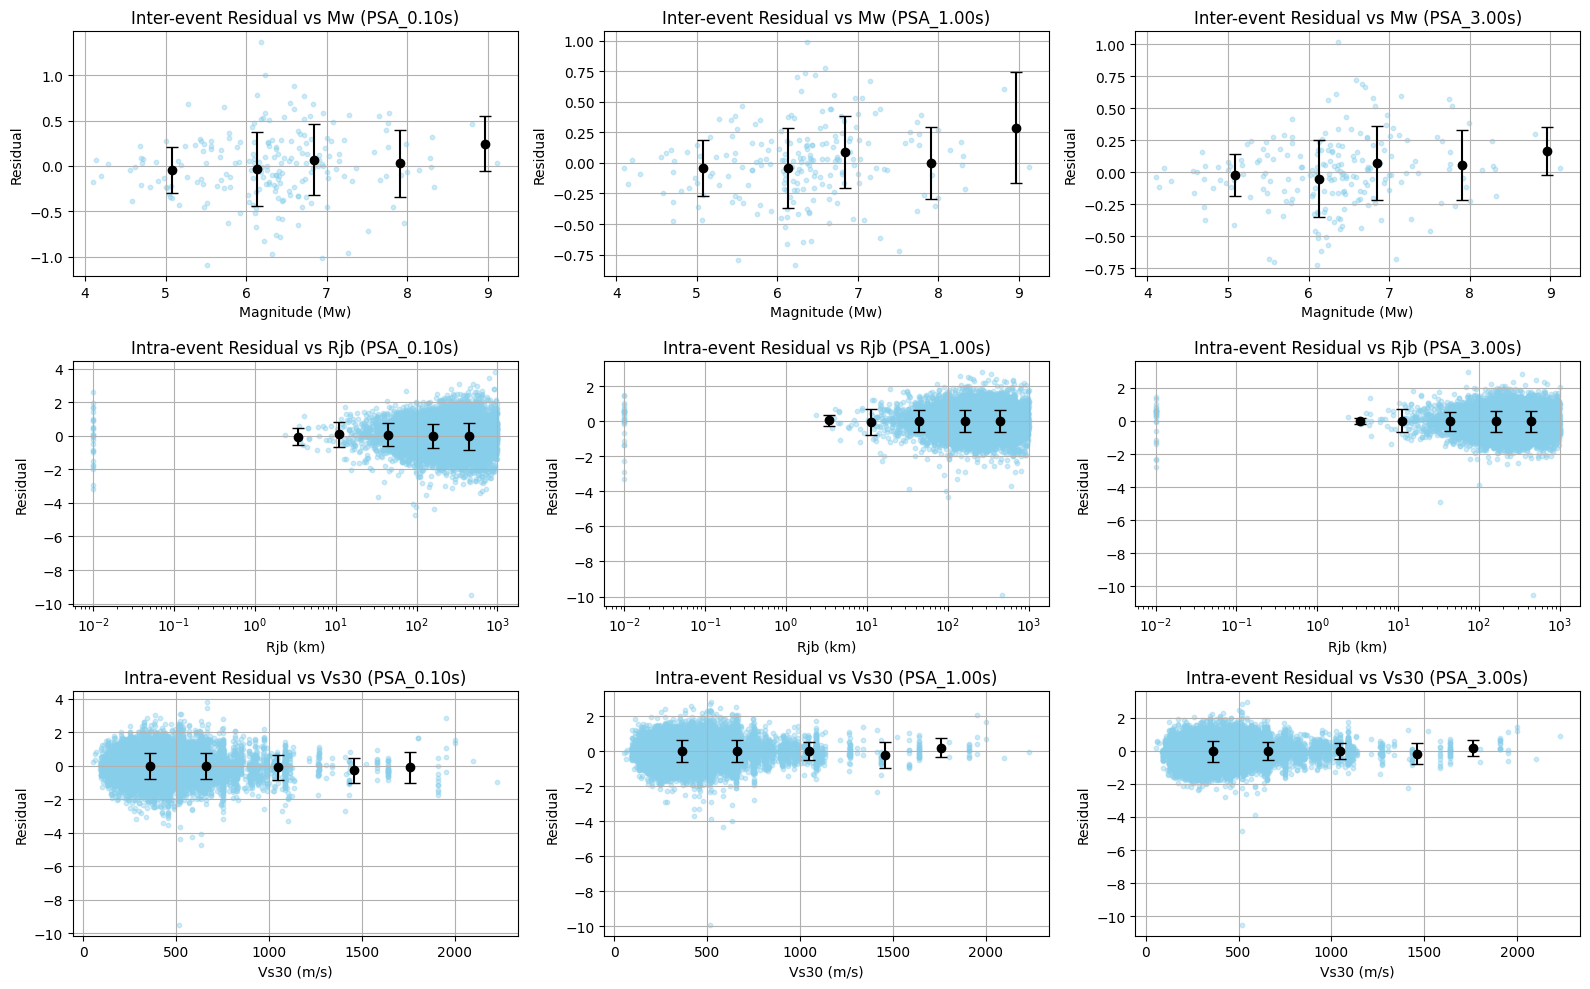

In [ ]:
time_periods = [0.01, 0.02, 0.03, 0.05, 0.075, 0.1, 0.15, 0.2, 0.3, 0.4,
                0.5, 0.75, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 5.0]

selected_indices = [5, 12, 16]  # Modify based on your period selection
selected_labels = [f"PSA_{time_periods[i]:.2f}s" for i in selected_indices]

# Plotting function with binned mean/std
def plot_residual_binned(x, y, xlabel, title, log_x=False, bins=6, ax=None):
    df = pd.DataFrame({'x': x, 'y': y})
    df['bin'] = pd.cut(df['x'], bins=bins)

    bin_centers = df.groupby('bin')['x'].mean()
    bin_means = df.groupby('bin')['y'].mean()
    bin_stds = df.groupby('bin')['y'].std()

    if ax is None:
        ax = plt.gca()
    ax.scatter(x, y, alpha=0.4, s=10, color='skyblue')
    ax.errorbar(bin_centers, bin_means, yerr=bin_stds, fmt='o', color='black', capsize=4)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Residual")
    ax.set_title(title)
    if log_x:
        ax.set_xscale("log")
    ax.grid(True)

# Plot setup
fig, axs = plt.subplots(3, 3, figsize=(16, 10))

for col, i in enumerate(selected_indices):
    # Inter-event vs Mw
    eq_unique, eq_idx = np.unique(EqIDs, return_index=True)
    Mw_vals = df['mag'].values[eq_idx]  # assuming 'mag' is moment magnitude
    plot_residual_binned(
        Mw_vals,
        inter_event[:, i],
        xlabel="Magnitude (Mw)",
        title=f"Inter-event Residual vs Mw ({selected_labels[col]})",
        bins=np.linspace(4.5, 9.5, 6),
        ax=axs[0, col]
    )

    # Intra-event vs Rjb
    plot_residual_binned(
        df['rjb'].values,
        intra_event[:, i],
        xlabel="Rjb (km)",
        title=f"Intra-event Residual vs Rjb ({selected_labels[col]})",
        bins=np.logspace(0, 3, 6),
        log_x=True,
        ax=axs[1, col]
    )

    # Intra-event vs Vs30
    plot_residual_binned(
        df['vs30'].values,
        intra_event[:, i],
        xlabel="Vs30 (m/s)",
        title=f"Intra-event Residual vs Vs30 ({selected_labels[col]})",
        bins=np.linspace(180, 2000, 6),
        ax=axs[2, col]
    )

plt.tight_layout()
plt.show()

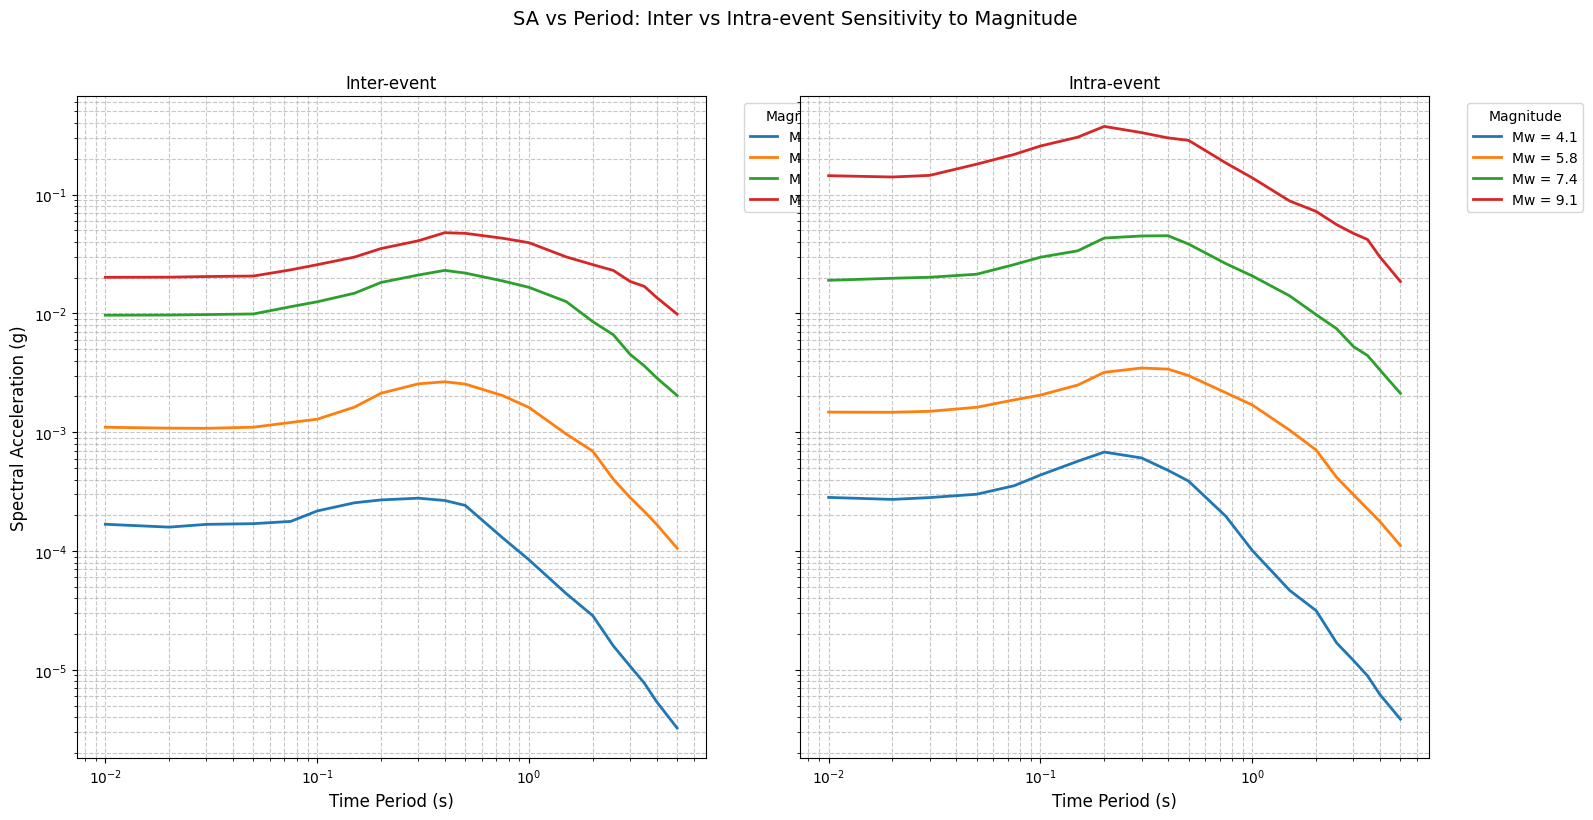

In [ ]:
periods = [float(t[1:].replace("pt", ".").replace("S", "")) for t in target_cols]


fixed_rjb = np.median(df['rjb'])
logrjb = np.log10(max(fixed_rjb, 0.01))
logvs30 = np.median(df['logvs30'])

# Mw range from data
mw_range = np.linspace(df['mag'].min(), df['mag'].max(), 4)

# --- Plot ---
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)  # Increased figure size

for idx, intra_inter_val in enumerate([0, 1]):
    ax = axes[idx]
    for mw in mw_range:
        X_input = np.array([[mw, fixed_rjb, logrjb, logvs30, intra_inter_val]])
        X_scaled = scaler_input.transform(X_input)
        y_pred_scaled = best_model.predict(X_scaled)
        y_pred_log = scaler_target.inverse_transform(y_pred_scaled)
        y_pred = np.exp(y_pred_log)

        label = f'Mw = {mw:.1f}'
        ax.semilogy(periods, y_pred.flatten(), label=label, linewidth=2)  # Using semilogy for log scale

    ax.set_title("Inter-event" if intra_inter_val == 0 else "Intra-event", fontsize=12)
    ax.set_xlabel("Time Period (s)", fontsize=12)
    ax.grid(True, which="both", linestyle='--', alpha=0.7)
    ax.set_xscale('log')  # Log scale for x-axis if periods vary widely

    if idx == 0:
        ax.set_ylabel("Spectral Acceleration (g)", fontsize=12)

    # Adjust legend position and size
    ax.legend(title="Magnitude", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.suptitle("SA vs Period: Inter vs Intra-event Sensitivity to Magnitude", fontsize=14, y=1.02)
plt.tight_layout()

# Add more vertical space between plots if needed
plt.subplots_adjust(wspace=0.15)

plt.show()

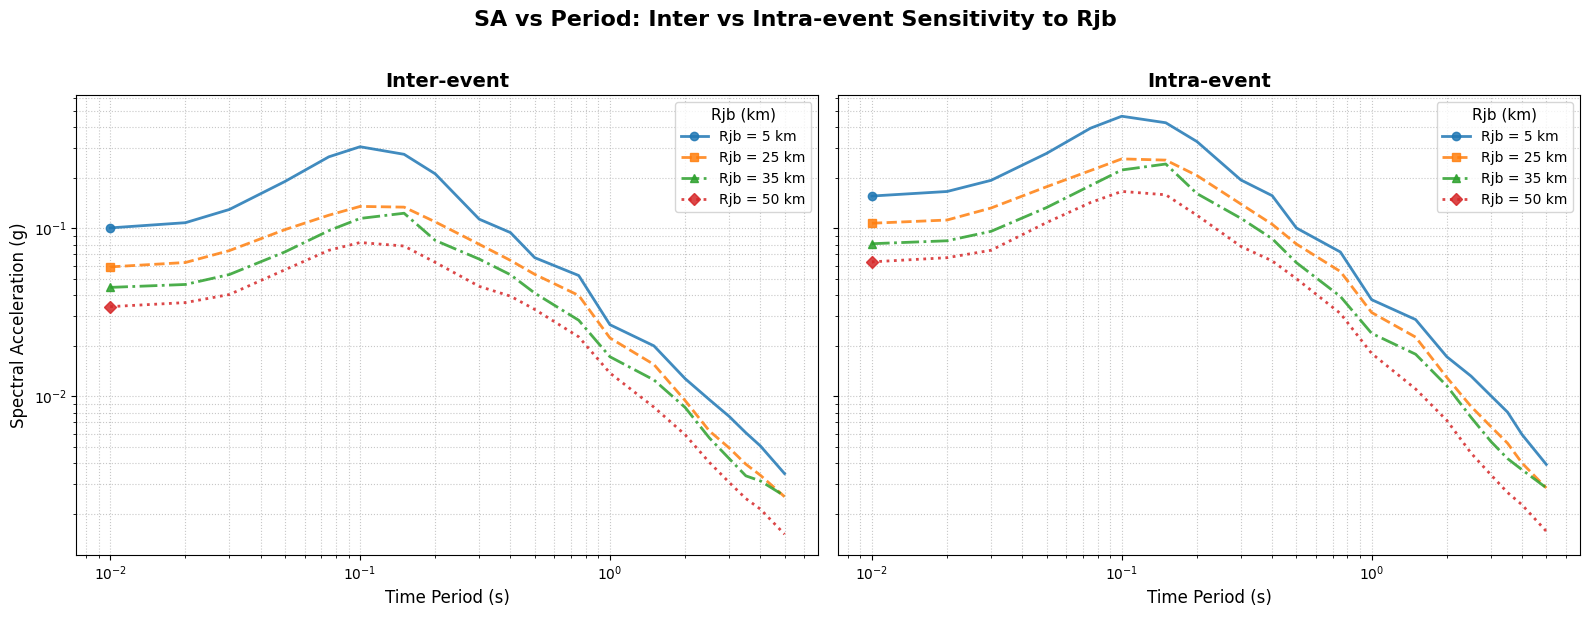

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define model inputs
fixed_mw = 6.5
fixed_vs30 = 760.0
logvs30 = np.log10(max(fixed_vs30, 0.01))

# Define Rjb values and plotting styles
rjb_values = [5, 25, 35, 50]
line_styles = ['-', '--', '-.', ':']
markers = ['o', 's', '^', 'D']

# Generate smooth period values (log-spaced) - Adjusted to match model output
periods = [float(t[1:].replace("pt", ".").replace("S", "")) for t in target_cols] # From 0.01s to 10s (adjust to your model)

# --- Plot ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

for idx, intra_inter_val in enumerate([0, 1]):
    ax = axes[idx]

    for i, rjb in enumerate(rjb_values):
        logrjb = np.log10(max(rjb, 0.01))

        # Create input with repeated periods for current Rjb
        X_input = np.array([[fixed_mw, rjb, logrjb, logvs30, intra_inter_val]]) #Removed len(periods)
        X_scaled = scaler_input.transform(X_input)

        # Predict SA
        y_pred_scaled = best_model.predict(X_scaled)
        y_pred_log = scaler_target.inverse_transform(y_pred_scaled)
        y_pred = np.exp(y_pred_log).flatten()  # SA in g

        # Plot
        label = f'Rjb = {rjb} km'
        ax.plot(periods, y_pred, # Changed to periods
                linestyle=line_styles[i % len(line_styles)],
                marker=markers[i % len(markers)],
                markevery=20,
                linewidth=2,
                alpha=0.85,
                label=label)

    ax.set_title("Inter-event" if intra_inter_val == 0 else "Intra-event",
                 fontsize=14, weight='bold')
    ax.set_xlabel("Time Period (s)", fontsize=12)
    ax.grid(True, which='both', linestyle=':', alpha=0.7)
    if idx == 0:
        ax.set_ylabel("Spectral Acceleration (g)", fontsize=12)
    ax.legend(title="Rjb (km)", fontsize=10, title_fontsize=11)

    # Log scale for better SA visualization
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.tick_params(axis='both', which='major', labelsize=10)

plt.suptitle("SA vs Period: Inter vs Intra-event Sensitivity to Rjb",
             fontsize=16, weight='bold', y=1.02)
plt.tight_layout()
plt.show()

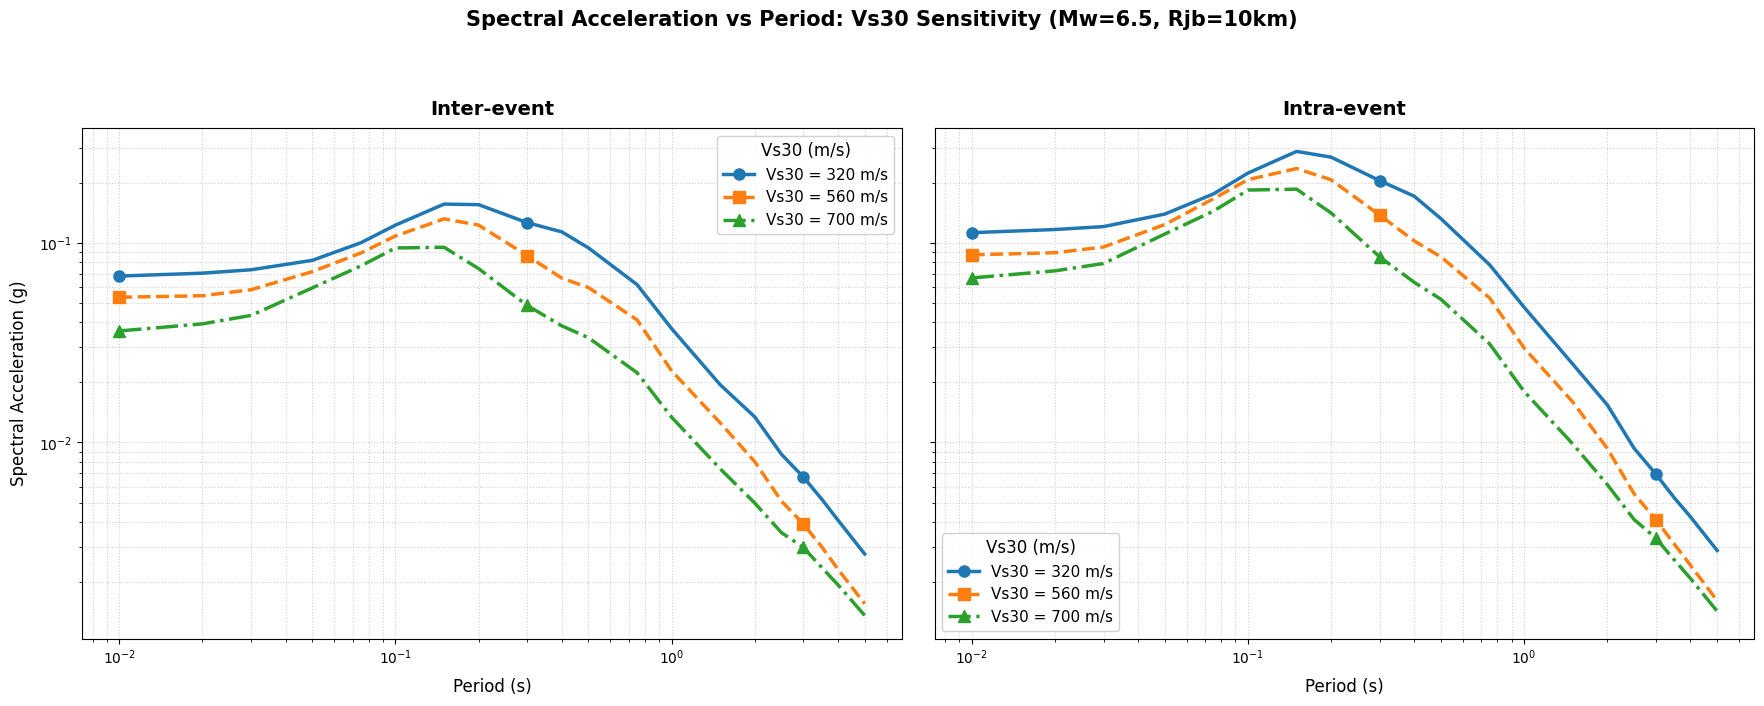

In [ ]:
fixed_mw = 6.5
fixed_rjb = 45
logrjb = np.log10(max(fixed_rjb, 0.01))

# Vs30 values to test
vs30_values = [320, 560, 700]

# Custom styling for each Vs30 curve
styles = {
    320: {'color': '#1f77b4', 'linestyle': '-', 'marker': 'o', 'linewidth': 2.5},
    560: {'color': '#ff7f0e', 'linestyle': '--', 'marker': 's', 'linewidth': 2.5},
    700: {'color': '#2ca02c', 'linestyle': '-.', 'marker': '^', 'linewidth': 2.5},
}

# --- Plot ---
fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True)

for idx, intra_inter_val in enumerate([0, 1]):
    ax = axes[idx]

    for vs30 in vs30_values:
        logvs30 = np.log10(max(vs30, 0.01))
        X_input = np.array([[fixed_mw, fixed_rjb, logrjb, logvs30, intra_inter_val]])
        X_scaled = scaler_input.transform(X_input)
        y_pred_scaled = best_model.predict(X_scaled)
        y_pred_log = scaler_target.inverse_transform(y_pred_scaled)
        y_pred = np.exp(y_pred_log)

        # Plot with custom style
        ax.plot(periods, y_pred.flatten(),
                label=f'Vs30 = {vs30} m/s',
                **styles[vs30],
                markersize=8,
                markevery=8)  # Show markers spaced out

    # Formatting
    ax.set_title("Inter-event" if intra_inter_val == 0 else "Intra-event",
                fontsize=14, pad=10, weight='bold')
    ax.set_xlabel("Period (s)", fontsize=12, labelpad=8)
    ax.grid(True, which='both', linestyle=':', alpha=0.6)

    if idx == 0:
        ax.set_ylabel("Spectral Acceleration (g)", fontsize=12, labelpad=8)

    # Logarithmic scales
    ax.set_xscale('log')
    ax.set_yscale('log')

    # Legend with improved layout
    ax.legend(title="Vs30 (m/s)",
             fontsize=11,
             title_fontsize=12,
             framealpha=0.9,
             loc='upper right' if intra_inter_val == 0 else 'lower left')

# Main title with adjusted position
plt.suptitle("Spectral Acceleration vs Period: Vs30 Sensitivity (Mw=6.5, Rjb=10km)",
            fontsize=15, weight='bold', y=1.02)

plt.tight_layout(pad=2.0)
plt.show()

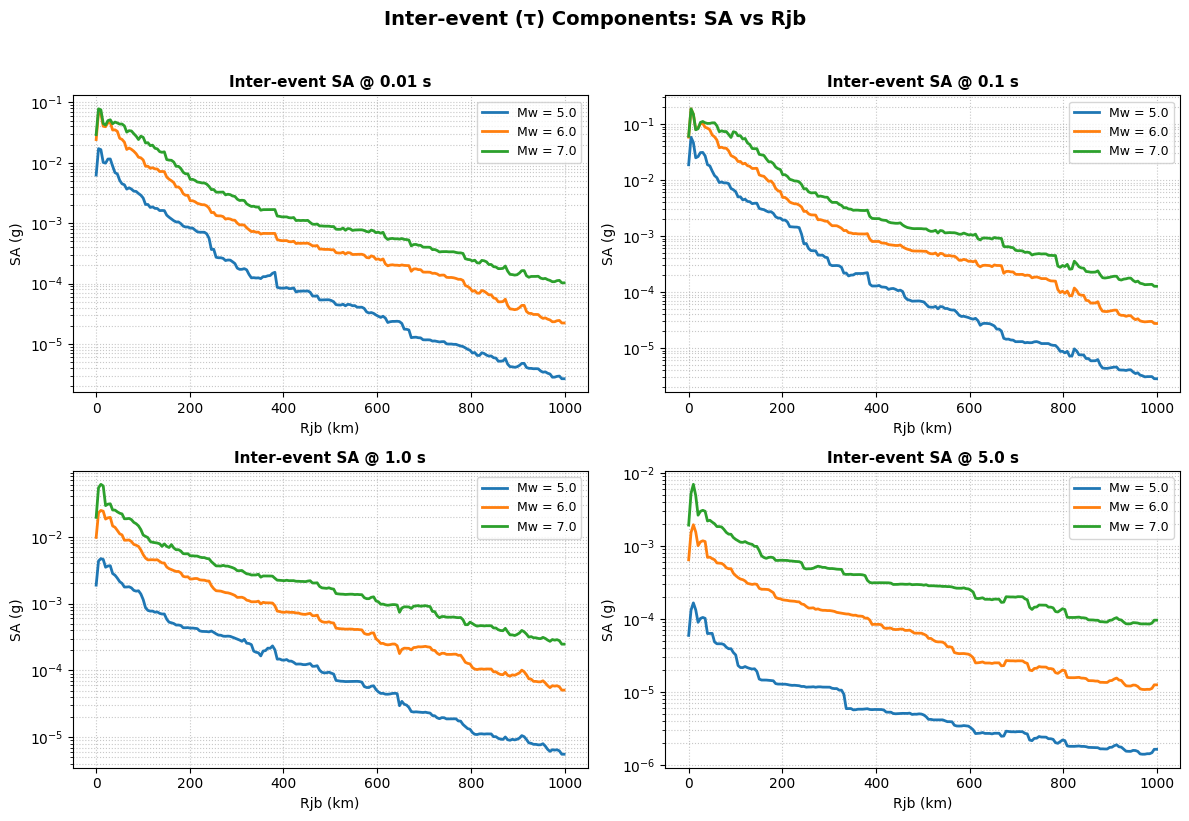

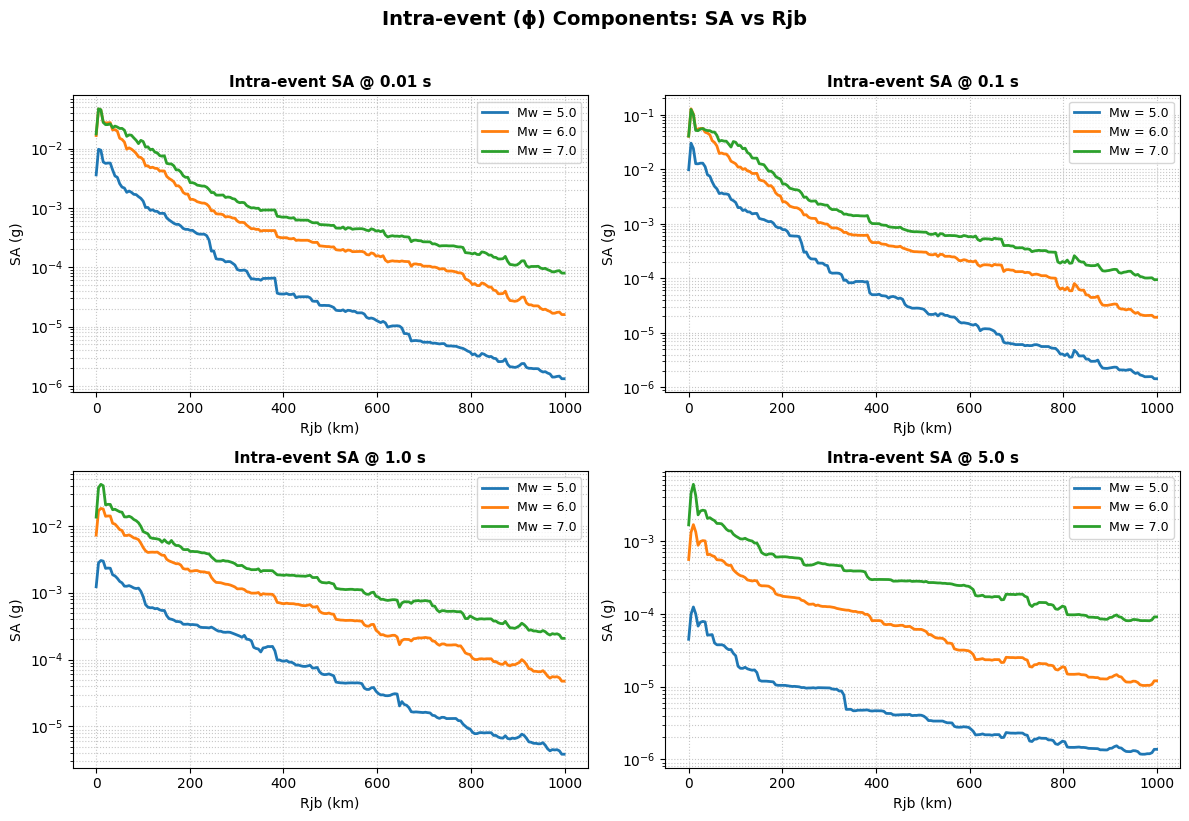

In [ ]:
# Get readable period values for selected output indices
selected_period_indices = [0, 5, 12, 19]
selected_periods = [float(target_cols[i][1:].replace('pt', '.').replace('S', '')) for i in selected_period_indices]

# Define Rjb range and Mw values
rjb_range = np.linspace(0.1, df['rjb'].max(), 200)  # start from 0.1 km to avoid log(0)
mw_values = [5.0, 6.0, 7.0]

fixed_vs30 = 760.0
logvs30 = np.log10(fixed_vs30)

# --- Inter-event component plots ---
plt.figure(figsize=(12, 8))
for idx, iT in enumerate(selected_period_indices):
    plt.subplot(2, 2, idx + 1)

    for mw in mw_values:
        sa_values = []
        for rjb in rjb_range:
            logrjb = np.log10(max(rjb, 0.01))
            X_input = np.array([[mw, rjb, logrjb, logvs30, 1]])  # 1 = inter-event
            X_scaled = scaler_input.transform(X_input)
            y_pred_scaled = best_model.predict(X_scaled)
            y_pred_log = scaler_target.inverse_transform(y_pred_scaled)
            sa_values.append(np.exp(y_pred_log[0, iT]))

        plt.semilogy(rjb_range, sa_values, label=f'Mw = {mw}', linewidth=2)

    plt.xlabel("Rjb (km)", fontsize=10)
    plt.ylabel("SA (g)", fontsize=10)
    plt.title(f"Inter-event SA @ {selected_periods[idx]} s", fontsize=11, weight='bold')
    plt.grid(True, which="both", linestyle=":", alpha=0.7)
    plt.legend(fontsize=9)

plt.suptitle("Inter-event (τ) Components: SA vs Rjb", fontsize=14, weight='bold', y=1.02)
plt.tight_layout()
plt.show()


# --- Intra-event component plots ---
plt.figure(figsize=(12, 8))
for idx, iT in enumerate(selected_period_indices):
    plt.subplot(2, 2, idx + 1)

    for mw in mw_values:
        sa_values = []
        for rjb in rjb_range:
            logrjb = np.log10(max(rjb, 0.01))
            X_input = np.array([[mw, rjb, logrjb, logvs30, 0]])  # 0 = intra-event
            X_scaled = scaler_input.transform(X_input)
            y_pred_scaled = best_model.predict(X_scaled)
            y_pred_log = scaler_target.inverse_transform(y_pred_scaled)
            sa_values.append(np.exp(y_pred_log[0, iT]))

        plt.semilogy(rjb_range, sa_values, label=f'Mw = {mw}', linewidth=2)

    plt.xlabel("Rjb (km)", fontsize=10)
    plt.ylabel("SA (g)", fontsize=10)
    plt.title(f"Intra-event SA @ {selected_periods[idx]} s", fontsize=11, weight='bold')
    plt.grid(True, which="both", linestyle=":", alpha=0.7)
    plt.legend(fontsize=9)

plt.suptitle("Intra-event (ϕ) Components: SA vs Rjb", fontsize=14, weight='bold', y=1.02)
plt.tight_layout()
plt.show()

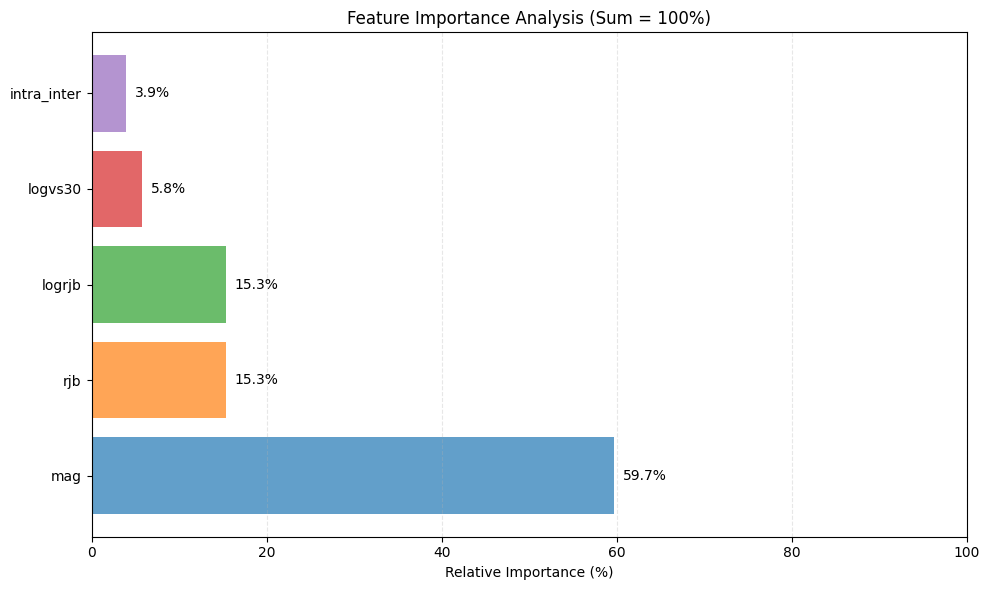

Sum of importance values: 100.0%


In [ ]:
from sklearn.inspection import permutation_importance

def scoring_fn(estimator, X, y):
    y_pred = estimator.predict(X)
    mse_per_period = np.mean((y - y_pred) ** 2, axis=0)
    return -np.mean(mse_per_period)

# Compute permutation importance
result = permutation_importance(
    best_model,
    X_val,
    y_val,
    scoring=scoring_fn,
    n_repeats=10,
    random_state=42
)

# Calculate raw and normalized importances
feature_importance = result.importances_mean
total_importance = np.sum(np.abs(feature_importance))
normalized_importance = np.round((feature_importance / total_importance) * 100, 1)

# Adjust last value for exact 100%
normalized_importance[-1] += 100 - np.round(np.sum(normalized_importance),1)

# Sort features
sorted_idx = np.argsort(normalized_importance)[::-1]
sorted_features = np.array(input_cols)[sorted_idx]
sorted_importance = normalized_importance[sorted_idx]

# Plotting
plt.figure(figsize=(10, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
bars = plt.barh(range(len(sorted_features)), sorted_importance, color=colors, alpha=0.7)

for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height()/2,
             f"{width:.1f}%", va='center', ha='left')

plt.yticks(range(len(sorted_features)), sorted_features)
plt.xlim(0, 100)
plt.xlabel("Relative Importance (%)")
plt.title("Feature Importance Analysis (Sum = 100%)")
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Print exact total
print(f"Sum of importance values: {np.round(np.sum(normalized_importance), 4)}%")


--- SHAP Summary for Output 0 ---


 99%|===================| 2152/2179 [01:27<00:01]       

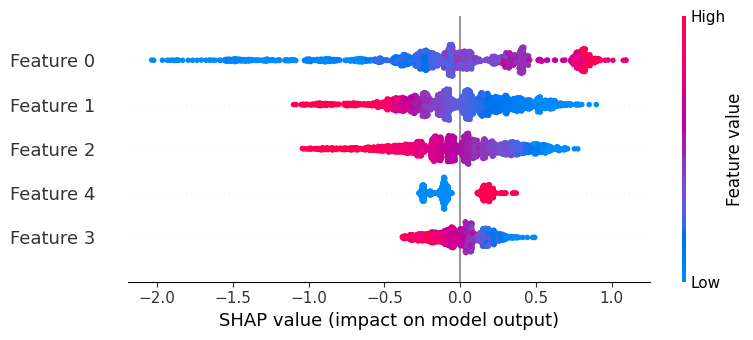


--- SHAP Summary for Output 1 ---


100%|===================| 2178/2179 [01:27<00:00]       

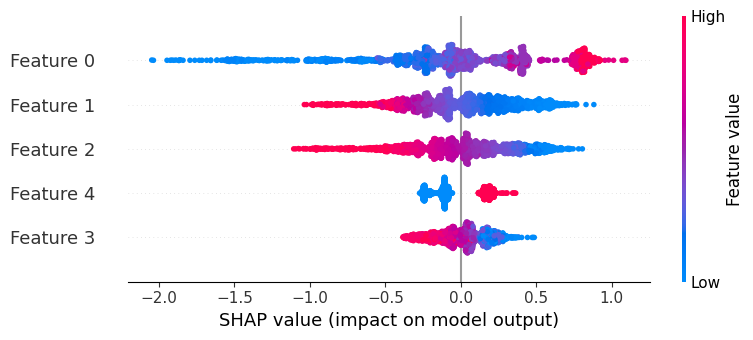


--- SHAP Summary for Output 2 ---


 99%|===================| 2161/2179 [01:25<00:00]       

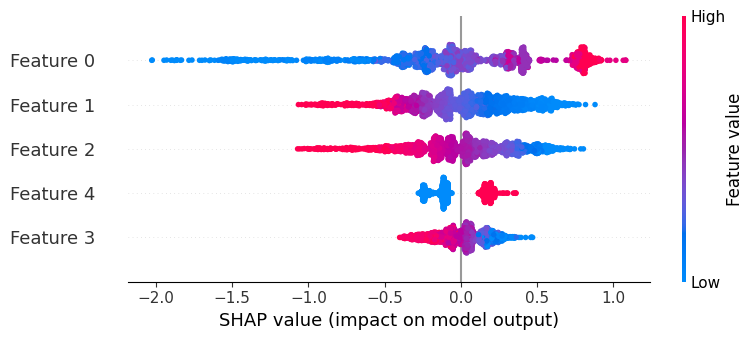


--- SHAP Summary for Output 3 ---


100%|===================| 2169/2179 [01:26<00:00]       

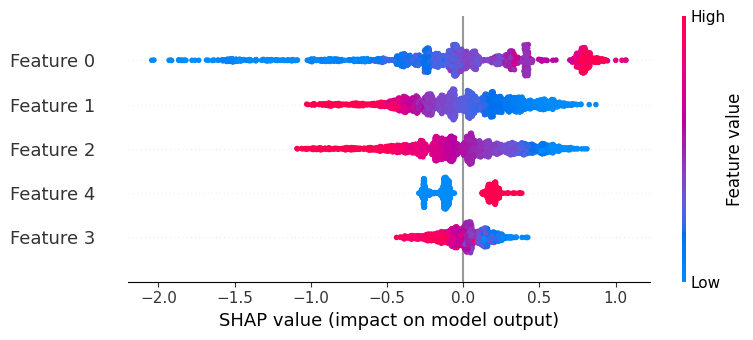


--- SHAP Summary for Output 4 ---


100%|===================| 2171/2179 [01:24<00:00]       

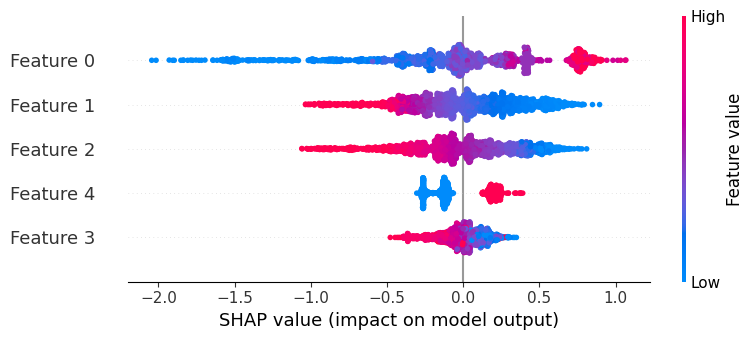


--- SHAP Summary for Output 5 ---


 99%|===================| 2167/2179 [01:23<00:00]       

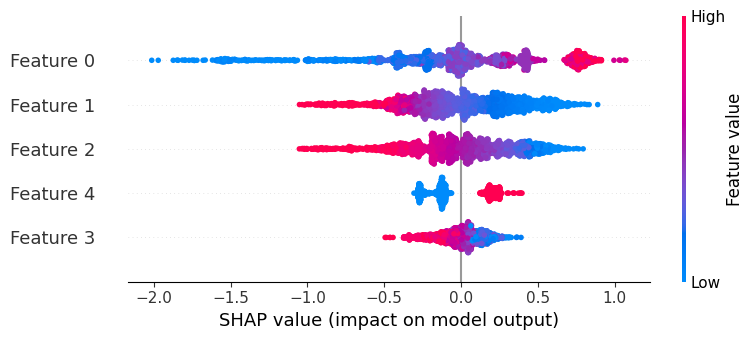


--- SHAP Summary for Output 6 ---


 99%|===================| 2155/2179 [01:33<00:01]       

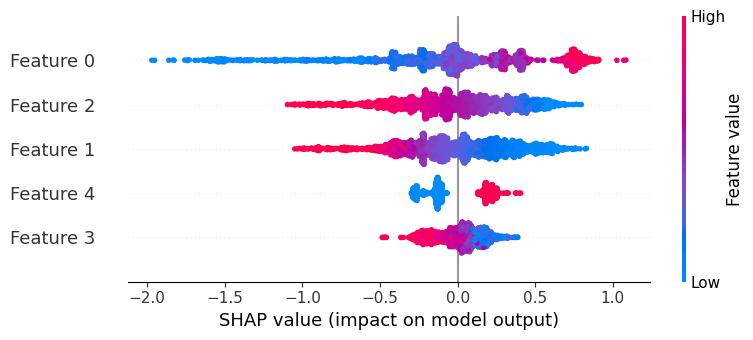


--- SHAP Summary for Output 7 ---


 99%|===================| 2168/2179 [01:27<00:00]       

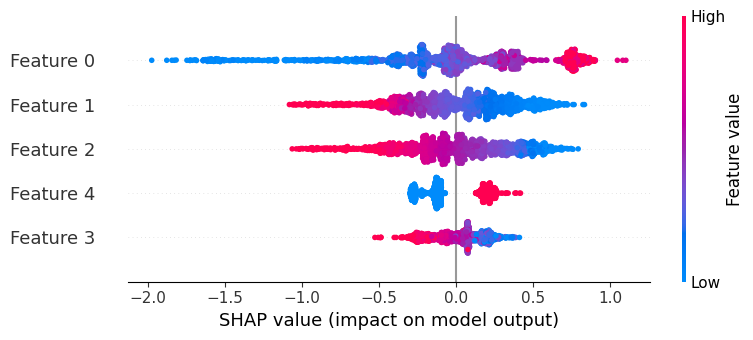


--- SHAP Summary for Output 8 ---


 99%|===================| 2152/2179 [01:33<00:01]       

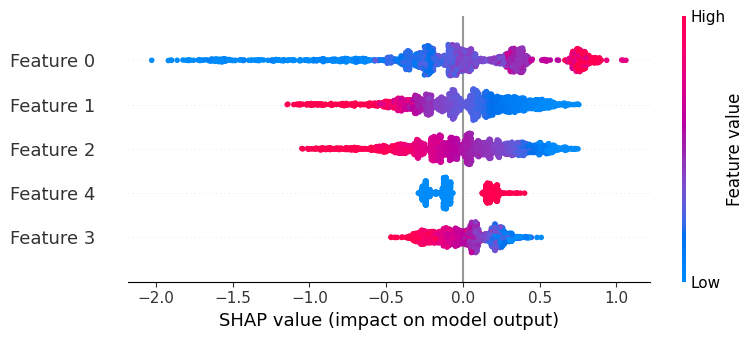


--- SHAP Summary for Output 9 ---


100%|===================| 2171/2179 [01:26<00:00]       

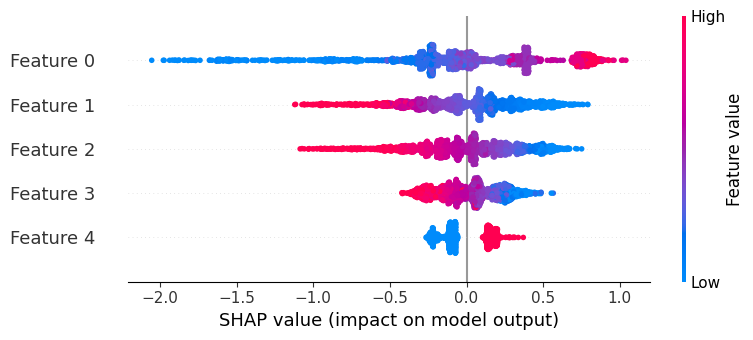


--- SHAP Summary for Output 10 ---


 99%|===================| 2168/2179 [01:26<00:00]       

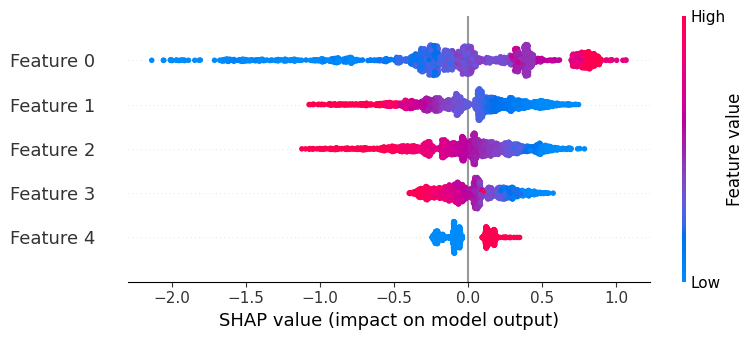


--- SHAP Summary for Output 11 ---


 99%|===================| 2168/2179 [01:25<00:00]       

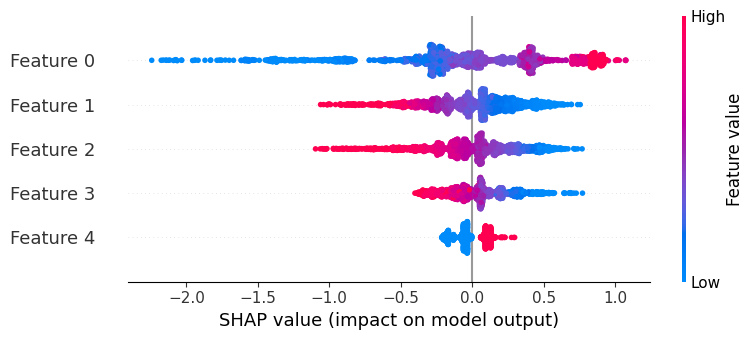


--- SHAP Summary for Output 12 ---


 99%|===================| 2157/2179 [01:24<00:00]       

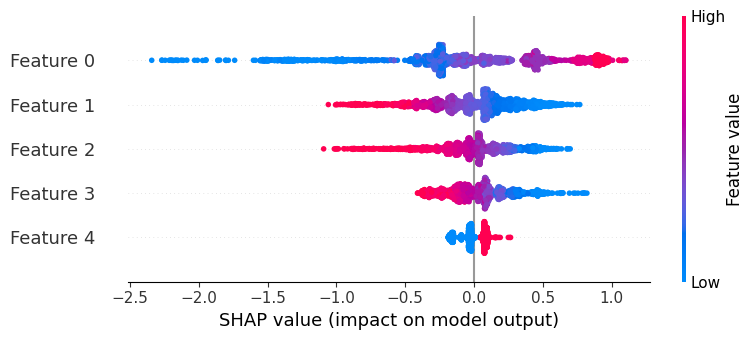


--- SHAP Summary for Output 13 ---


 99%|===================| 2164/2179 [01:24<00:00]       

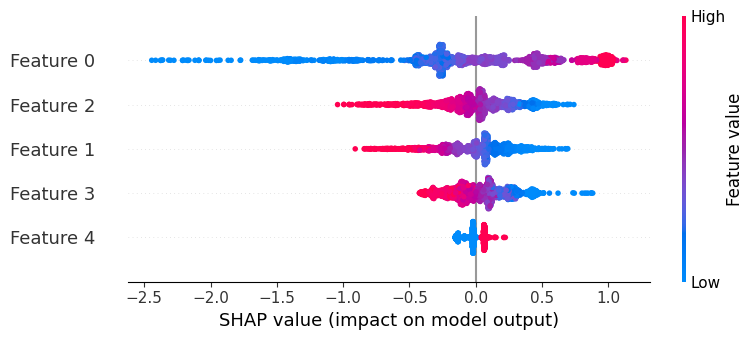


--- SHAP Summary for Output 14 ---


 99%|===================| 2158/2179 [01:23<00:00]       

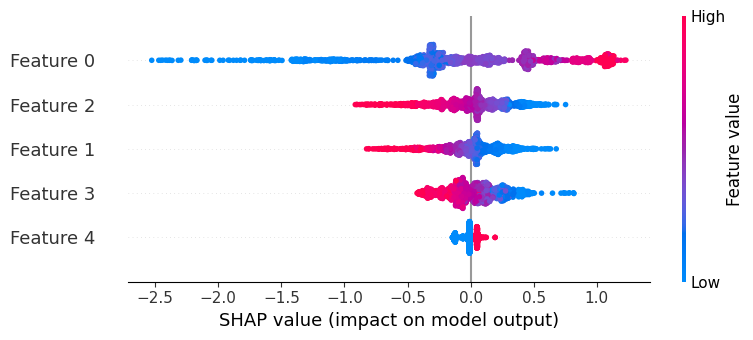


--- SHAP Summary for Output 15 ---


 99%|===================| 2165/2179 [01:22<00:00]       

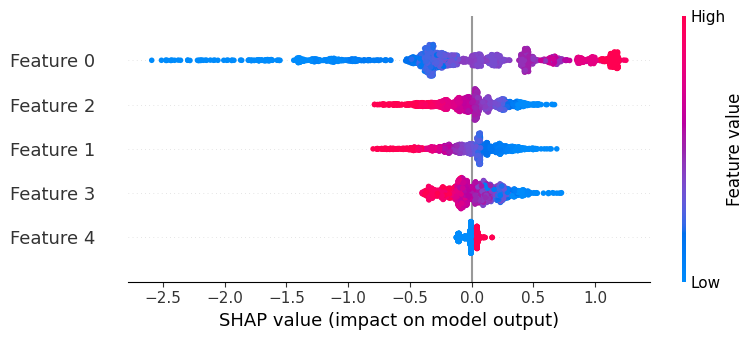


--- SHAP Summary for Output 16 ---


 99%|===================| 2162/2179 [01:23<00:00]       

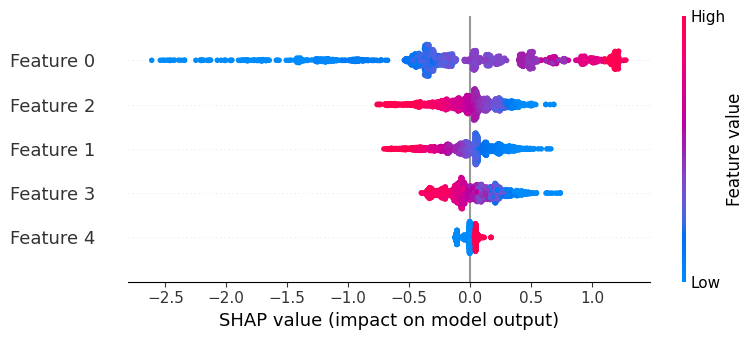


--- SHAP Summary for Output 17 ---


 99%|===================| 2154/2179 [01:20<00:00]       

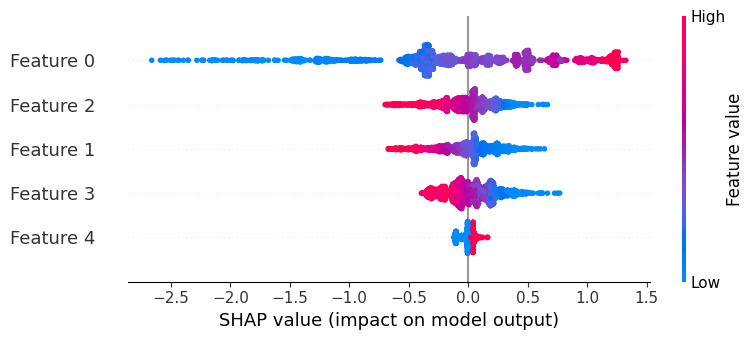


--- SHAP Summary for Output 18 ---


 99%|===================| 2160/2179 [01:22<00:00]       

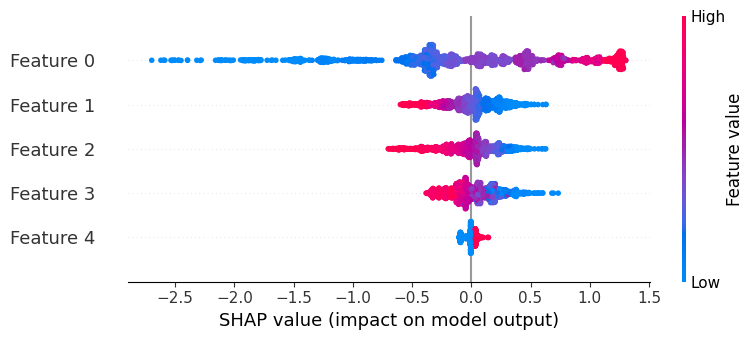


--- SHAP Summary for Output 19 ---


 99%|===================| 2160/2179 [01:23<00:00]       

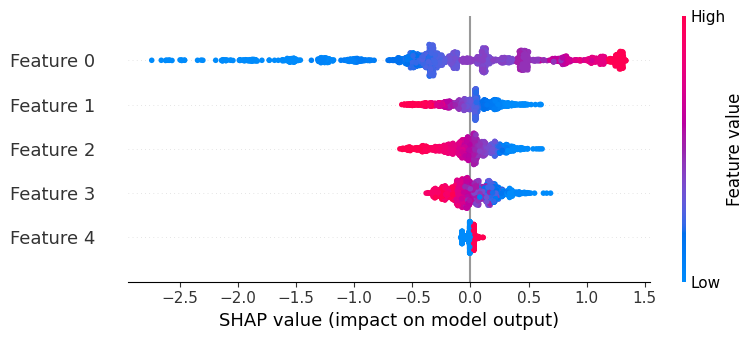

In [ ]:
import shap

for i in range(y_train.shape[1]):
    print(f"\n--- SHAP Summary for Output {i} ---")
    explainer = shap.Explainer(model.estimators_[i], X_train)
    shap_values = explainer(X_val)
    shap.summary_plot(shap_values, X_val, show=True)

In [ ]:
results = []

for i, col in enumerate(target_cols):
    y_true = y_true_log[:, i]  # True values for the current target

    # Get predictions for ALL samples for the current target:
    X_input_all = np.column_stack([df['mag'], df['rjb'], df['logrjb'], df['logvs30'], df['intra_inter']])
    X_input_all_scaled = scaler_input.transform(X_input_all)
    y_pred_scaled_all = best_model.predict(X_input_all_scaled)
    y_pred_log_all = scaler_target.inverse_transform(y_pred_scaled_all)
    y_pred = y_pred_log_all[:, i]  # Predictions for the current target

    residuals = y_true - y_pred

    temp_df = pd.DataFrame({
        'event': EqIDs,
        'residuals': residuals
    })

    event_means = temp_df.groupby('event')['residuals'].mean()
    tau = event_means.std(ddof=0)

    phi_sq_list = []
    for _, group in temp_df.groupby('event'):
        res = group['residuals'].values
        if len(res) > 1:
            phi_sq_list.extend((res - res.mean())**2)
    phi = np.sqrt(np.mean(phi_sq_list))

    r2 = r2_score(y_true, y_pred)  # Now y_true and y_pred have the same length
    total = np.sqrt(tau**2 + phi**2)

    results.append({
        'Target Variable': col,
        'R2': r2,
        'Inter-Std (τ)': tau,
        'Intra-Std (φ)': phi,
        'Total Std': total
    })

table02 = pd.DataFrame(results).round(4)
print(table02)

   Target Variable      R2  Inter-Std (τ)  Intra-Std (φ)  Total Std
0         T0pt010S  0.9098         0.4898         0.6348     0.8018
1         T0pt020S  0.9093         0.4921         0.6373     0.8052
2         T0pt030S  0.9080         0.4999         0.6440     0.8153
3         T0pt050S  0.9024         0.5221         0.6731     0.8518
4         T0pt075S  0.8939         0.5441         0.7192     0.9018
5         T0pt100S  0.8890         0.5591         0.7488     0.9346
6         T0pt150S  0.8918         0.5400         0.7442     0.9195
7         T0pt200S  0.8964         0.5206         0.7261     0.8934
8         T0pt300S  0.9052         0.4966         0.6788     0.8410
9         T0pt400S  0.9098         0.4954         0.6480     0.8157
10        T0pt500S  0.9107         0.4866         0.6327     0.7982
11        T0pt750S  0.9063         0.4666         0.6250     0.7800
12        T1pt000S  0.9004         0.4595         0.6307     0.7804
13        T1pt500S  0.8914         0.4358       